In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os,sys
import pickle
import pyxdf as xdf
from scipy import signal
from scipy import interpolate 
from sklearn.preprocessing import Normalizer
sys.path.append('../models/model_based_files/')
sys.path.append('../models/Data_based_models/CNN9/')
from Speed_Recognition_3 import SpeedRecProcessing as SRP
from model_2 import Speed_model_2 as SP
from model2 import CNN as CLSTM
#from model2 import CNN_LSTM as CLSTM
from preprocessing1 import preprocess,split
from dataset import IMU

/home/prestige/Documents/venvs/activity_class/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
sns.set_color_codes('dark')
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('font', size=25)          # controls default text sizes

# Data Prep

In [3]:
# Data Container
acc_data=[]
X=[]
# Load data
for run in range(1,7):
    streams,header=xdf.load_xdf(f'../Recordings/Testing_sub-P001/sub-test2_ses-S001_task-Default_run-00{run}_eeg.xdf'
)
    for stream in streams:
        if stream['info']['name'][0]=='polar accel':
            x,Y=split(stream['time_series'],1,interval=0.4,window=1,sample_rate=200)
            print(x.shape)
            acc_data.append(stream['time_series'])
            X.append(x)
            
            


(324, 200, 1)
(332, 200, 1)
(326, 200, 1)
(315, 200, 1)
(329, 200, 1)
(780, 200, 1)


In [4]:
runs={'4':1.38,'1':0.98,'2':1.11,'3':1.25,'5':1.48}

# Phase plane diagram

In [5]:
def split_datum(acc_data):

    run_1=acc_data[3000:-3000]
    # finding peaks
    print(run_1[:,0].shape)
    peaks=signal.find_peaks(run_1[:,0],height=-900,distance=160)[0]
    print(len(peaks))
    data_1=[]
    data_raw=[]

    for i,peak in enumerate(peaks):
        if i==0:
            continue

        split_data=run_1[peaks[i-1]:peak,0]
        data_raw.append(split_data)
        xp=np.arange(0,200,1)
        xo=np.arange(0,len(split_data),1)
        try:
            f2=interpolate.interp1d(xo,split_data,kind='cubic')    
            yp=f2(xp)
            data_1.append(yp)
        
        except:
            pass

    return np.array(data_1),np.array(data_raw)

In [7]:
for split_data in acc_data:
    run,_=split_datum(split_data)
    for i in range(len(run)):
        

(21104,)
89
(69, 200)
(21712,)
90
(89, 200)
(21264,)
85
(84, 200)
(20368,)
84
(80, 200)
(21488,)
93
(80, 200)
(57584,)
236
(227, 200)


/tmp/ipykernel_11736/1657481095.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_1),np.array(data_raw)


In [7]:
data_1=np.array(data_1)
mean=np.mean(data_1,axis=0)
std=np.std(data_1,axis=0)
plt.plot(mean)
plt.fill_between(np.arange(0,200,1),mean-std,mean+std,alpha=0.5)

NameError: name 'data_1' is not defined

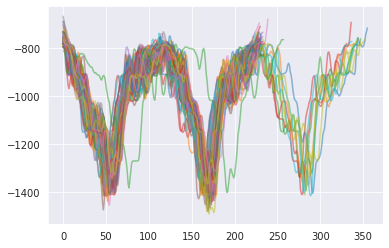

In [53]:
for i in range(len(data_raw)):
    plt.plot(data_raw[i],alpha=0.5)

In [8]:
def pos_vel(b,a,data):
    time=np.arange(0,len(data)/200,1/200)
    vel=[0]
    pos=[0]
    data=data
    data=signal.filtfilt(b,a,data)
    for i in range(len(data)-2):
        v=vel[0]+data[i]*(time[i+1]-time[i])
        vel.append(v)
    #vel=signal.detrend(vel)

    for i in range(len(vel)-2):
        p=pos[0]+vel[i]*(time[i+1]-time[i])
        pos.append(p)
    pos=signal.detrend(pos)

    return pos,vel
    

In [99]:
b,a=signal.butter(5,20/100,'low')
velocity=[]
position=[]
for i in range(len(data_1)):
    p,v=pos_vel(b,a,data_1[i])
    velocity.append(v)
    position.append(p)
    


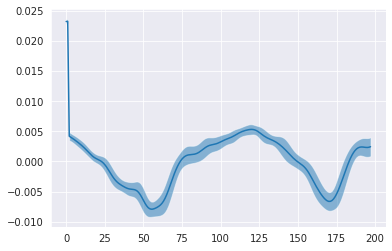

In [100]:
mean_pos=np.mean(position,axis=0)
std_pos=np.std(position,axis=0)
mean_vel=np.mean(velocity,axis=0)
std_vel=np.std(velocity,axis=0)

plt.figure()
plt.plot(mean_pos)
plt.fill_between(np.arange(0,198,1),mean_pos-std_pos,mean_pos+std_pos,alpha=0.5)


In [10]:
instance=SRP(h=110,c=0.5)


2023-05-01 14:43:09.805 (2279.395s) [python          ]      netinterfaces.cpp:91    INFO| netif 'lo' (status: 0, multicast: 1, broadcast: 0)
2023-05-01 14:43:09.805 (2279.396s) [python          ]      netinterfaces.cpp:91    INFO| netif 'wlo1' (status: 4096, multicast: 1, broadcast: 2)
2023-05-01 14:43:09.805 (2279.396s) [python          ]      netinterfaces.cpp:91    INFO| netif 'lo' (status: 0, multicast: 1, broadcast: 0)
2023-05-01 14:43:09.806 (2279.396s) [python          ]      netinterfaces.cpp:91    INFO| netif 'wlo1' (status: 4096, multicast: 1, broadcast: 2)
2023-05-01 14:43:09.806 (2279.396s) [python          ]      netinterfaces.cpp:102   INFO| 	IPv4 addr: a00009d
2023-05-01 14:43:09.806 (2279.396s) [python          ]      netinterfaces.cpp:91    INFO| netif 'lo' (status: 0, multicast: 1, broadcast: 0)
2023-05-01 14:43:09.806 (2279.396s) [python          ]      netinterfaces.cpp:91    INFO| netif 'wlo1' (status: 4096, multicast: 1, broadcast: 2)
2023-05-01 14:43:09.806 (2279

In [112]:
posistion=[]
velocity=[]
for i in range(len(data_1)):
    pos=instance.get_deltas(data=data_1[i],delta_y=False,delta_t=False,delta_x=False,velocities=True)
    position.append(pos[0])
    velocity.append(pos[1])


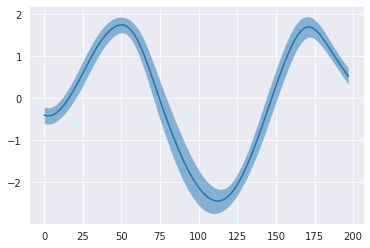

In [119]:
pos_mean=np.mean(position,axis=0)
pos_std=np.std(position,axis=0)
plt.figure()
plt.plot(pos_mean)
plt.fill_between(np.arange(0,198,1),pos_mean-pos_std,pos_mean+pos_std,alpha=0.5)

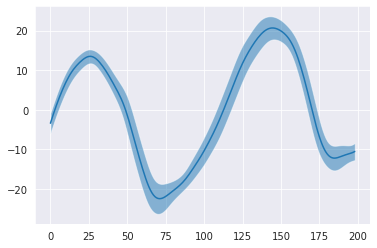

In [115]:
vel_mean=np.mean(velocity,axis=0)
vel_std=np.std(velocity,axis=0)
plt.figure()    
plt.plot(vel_mean)
plt.fill_between(np.arange(0,199,1),vel_mean-vel_std,vel_mean+vel_std,alpha=0.5)

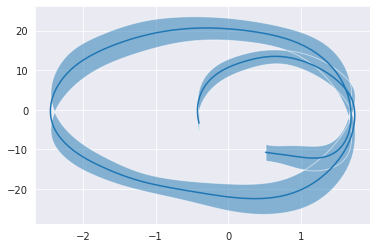

In [124]:
plt.plot(pos_mean,vel_mean[:-1])
plt.fill_between(pos_mean,vel_mean[:-1]-vel_std[:-1],vel_mean[:-1]+vel_std[:-1],alpha=0.5)


In [11]:
position_mean=[]
position_std=[]
velocity_mean=[]
velocity_std=[]

for data in acc_data:
    int_data,_=split_datum(data)
    pos=[]
    vel=[]
    for i in range(len(int_data)):
        p=instance.get_deltas(data=int_data[i],delta_y=False,delta_t=False,delta_x=False,velocities=True)
        pos.append(p[0])
        vel.append(p[1])
    pos_mean=np.mean(pos,axis=0)
    pos_std=np.std(pos,axis=0)
    vel_mean=np.mean(vel,axis=0)
    vel_std=np.std(vel,axis=0)
    position_mean.append(pos_mean)
    position_std.append(pos_std)
    velocity_mean.append(vel_mean)
    velocity_std.append(vel_std)


(21104,)
89
(21712,)
90
(21264,)
85


/tmp/ipykernel_11736/1657481095.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_1),np.array(data_raw)


(20368,)
84
(21488,)
93
(57584,)
236


Text(0.5, 1.0, 'COM Position vs Time')

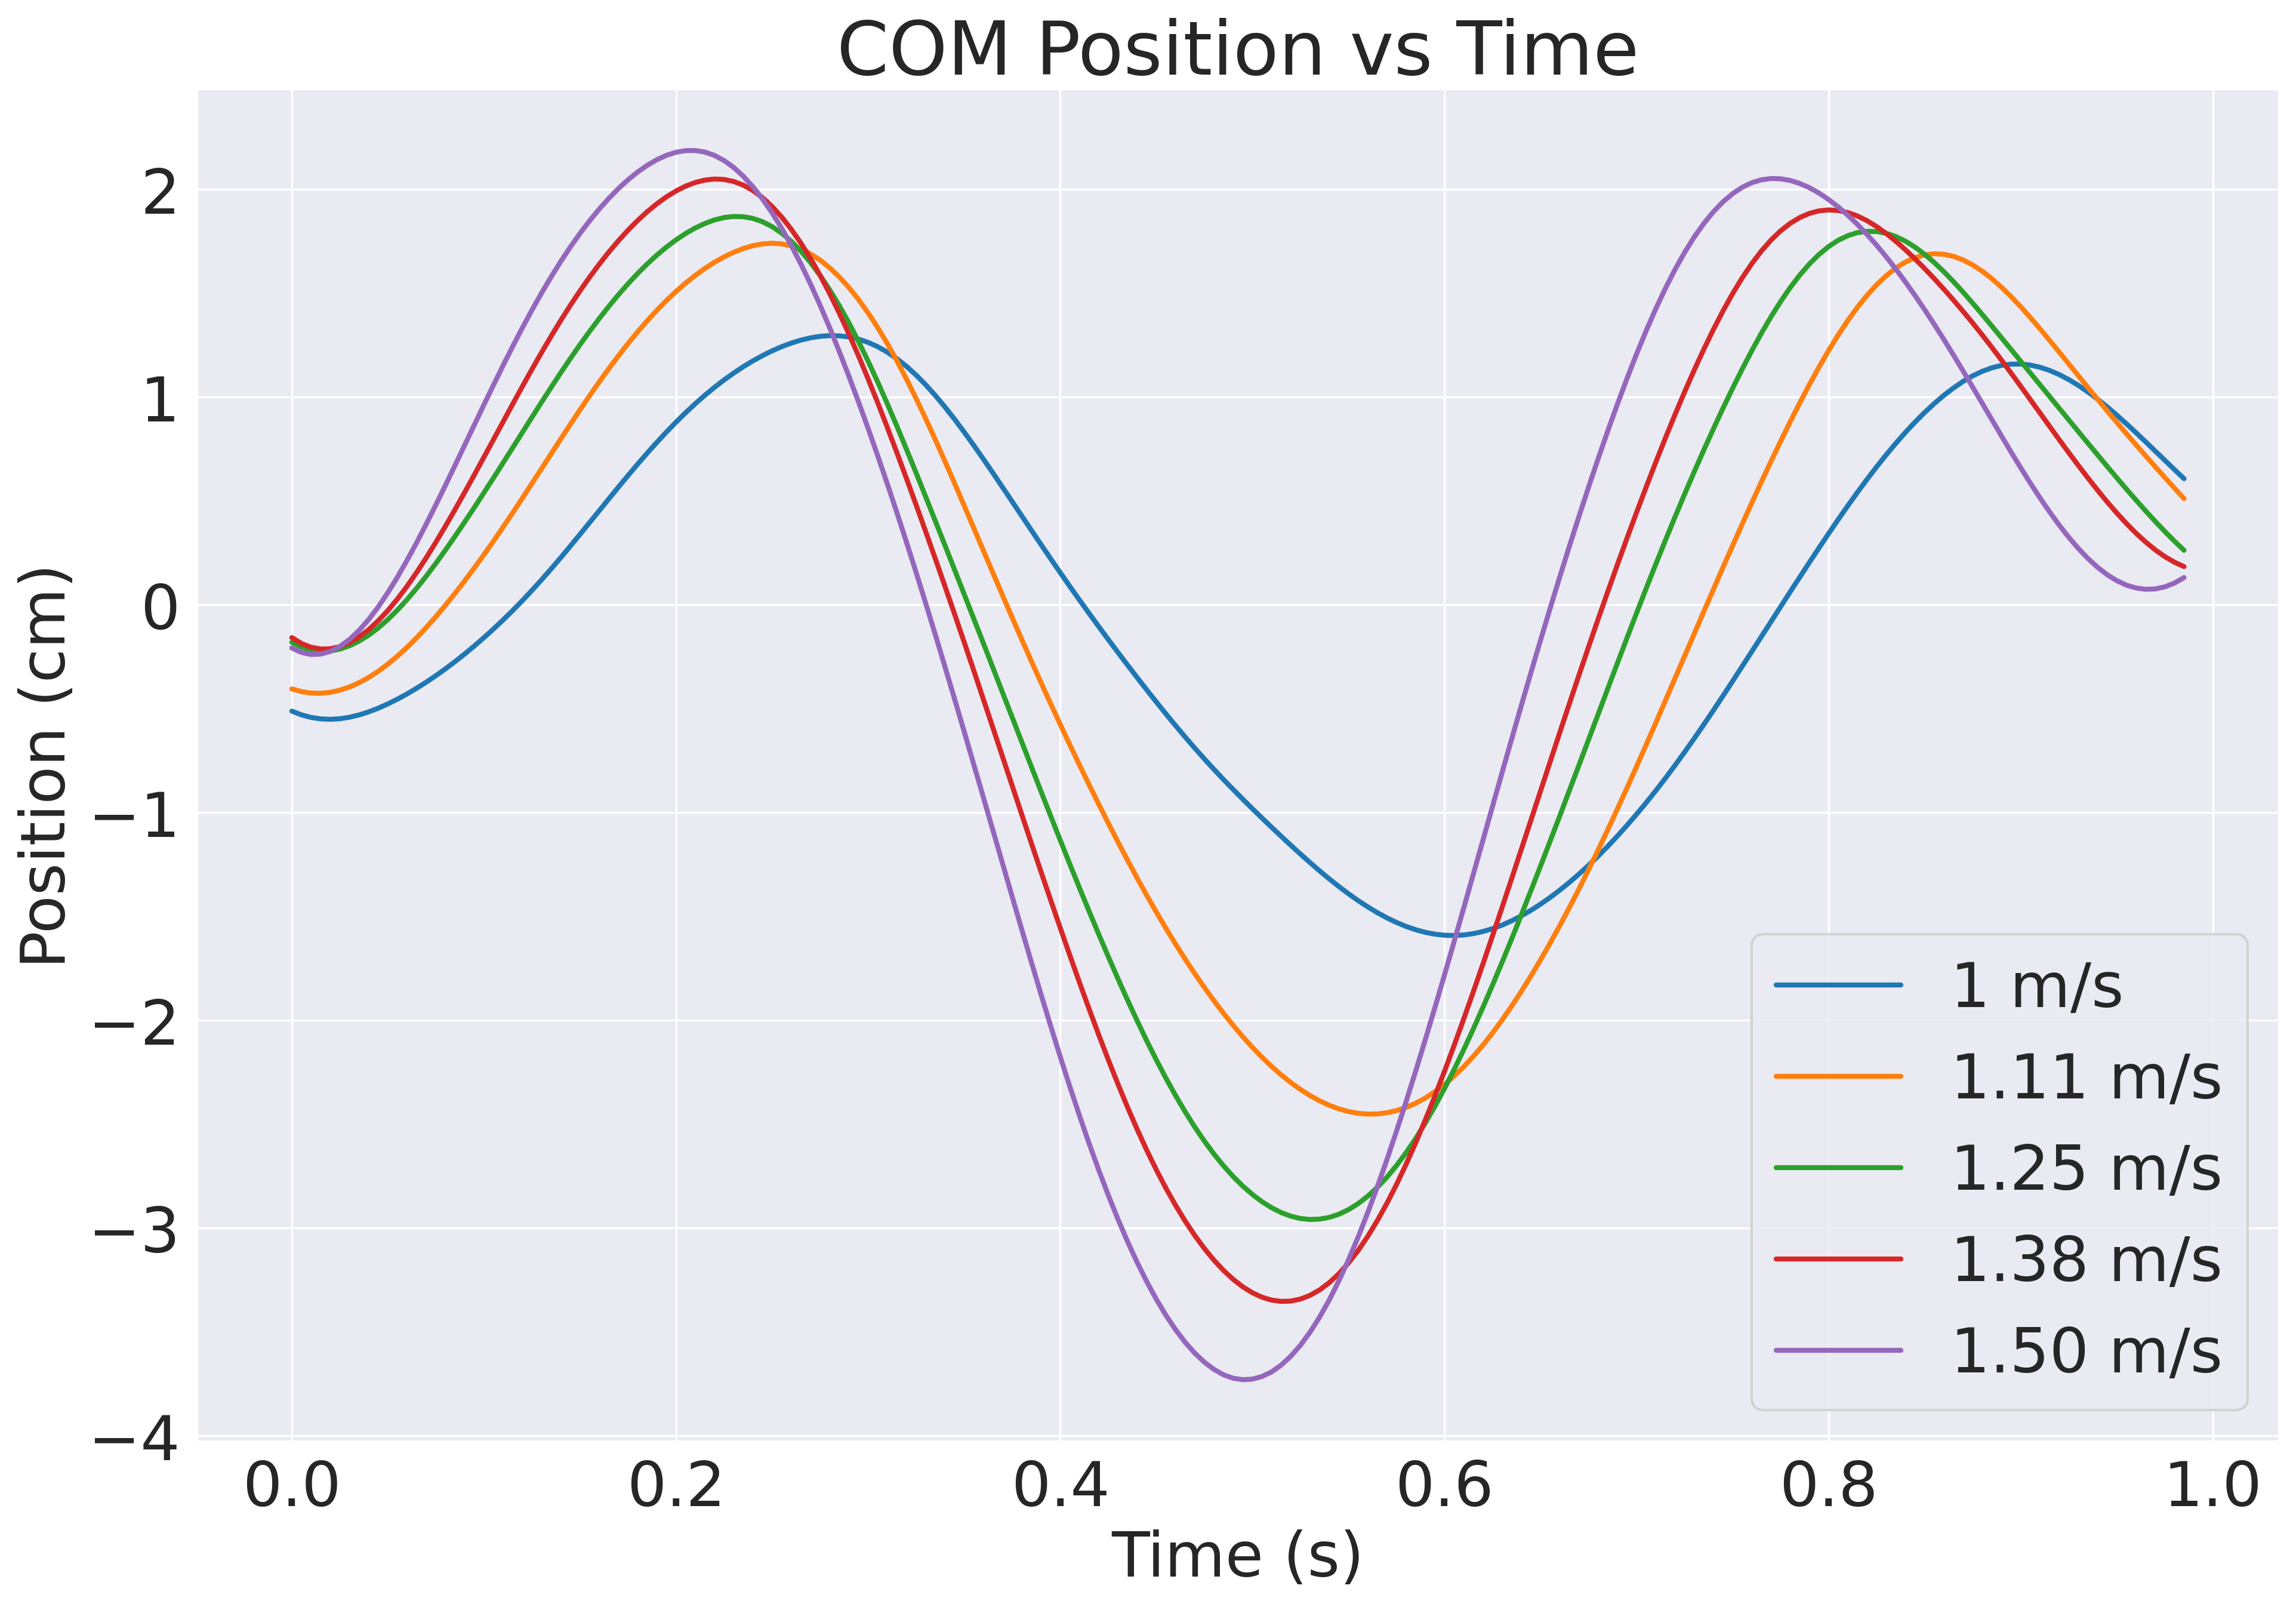

In [17]:
fig=plt.figure(figsize=(15,10),dpi=300)
ax1=fig.add_subplot(111)
legend=['1 m/s','1.11 m/s','1.25 m/s','1.38 m/s','1.50 m/s']
for i in range(len(position_mean)-1):
    ax1.plot(np.arange(0,len(position_mean[i])/200,1/200),position_mean[i],linewidth=2,label=legend[i])
ax1.legend(loc='lower right')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Position (cm)')
ax1.set_title('COM Position vs Time')



/tmp/ipykernel_5264/129895000.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  legend.show()


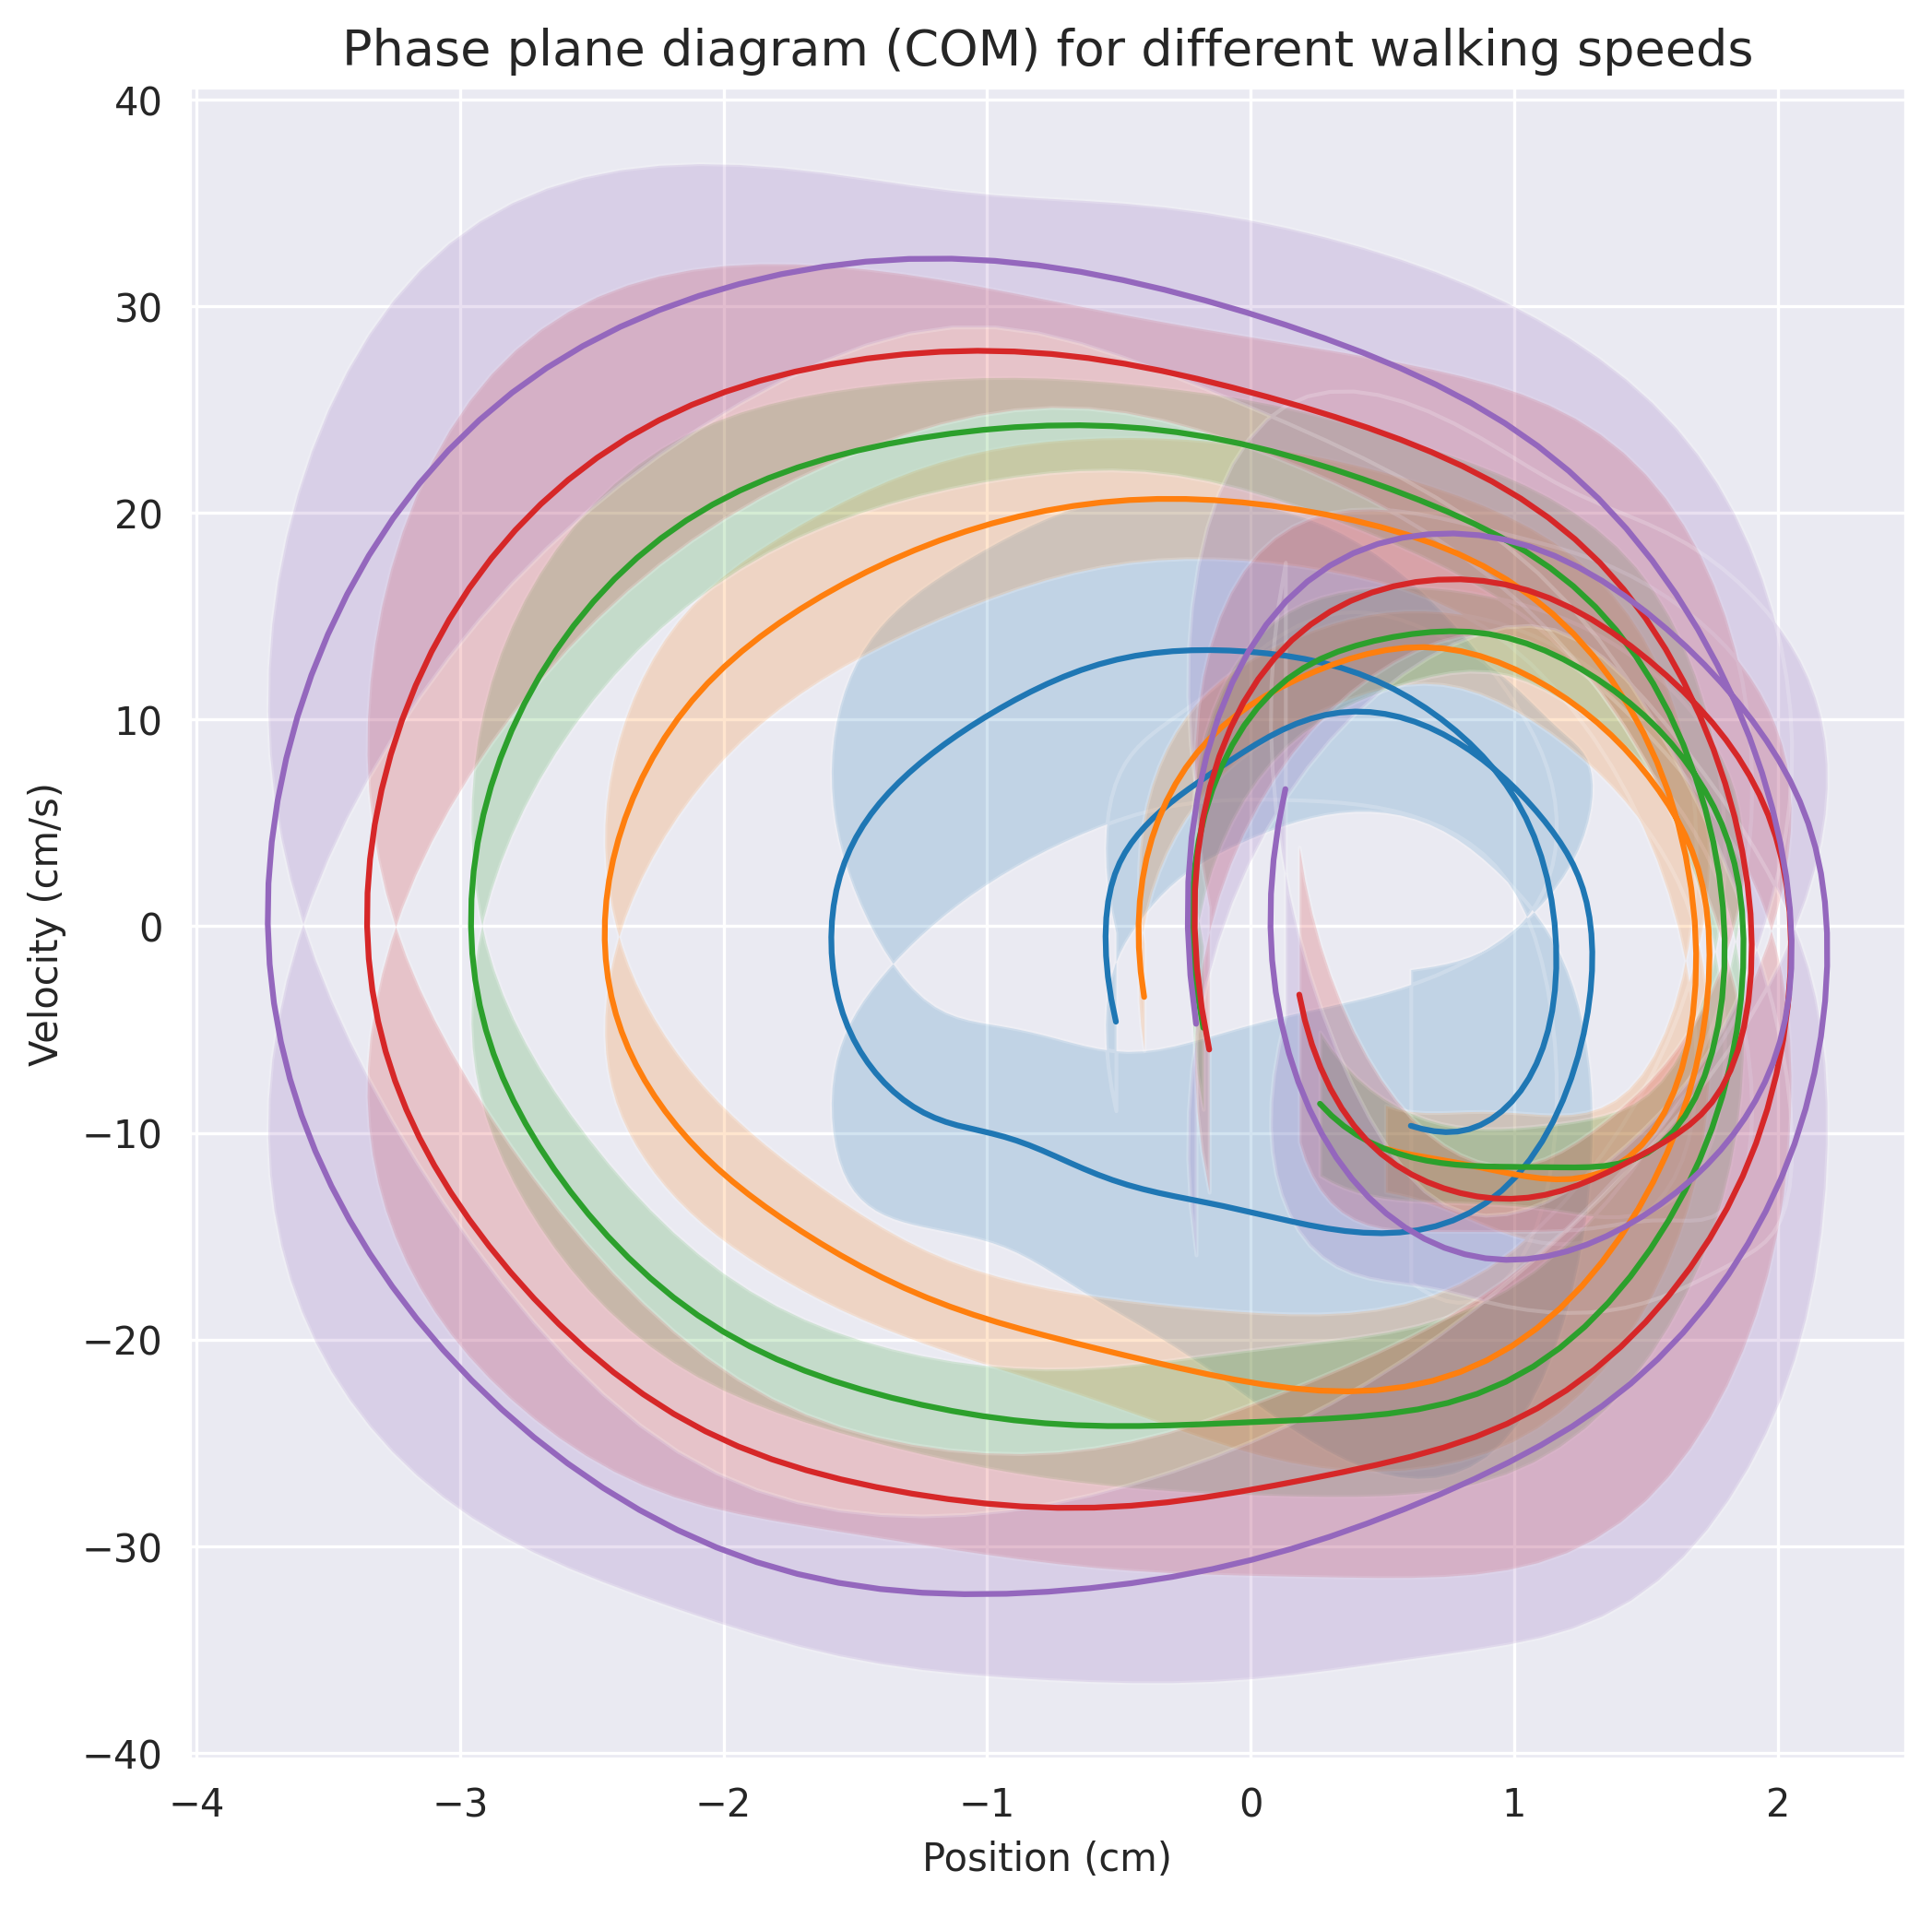

<Figure size 600x300 with 0 Axes>

In [182]:
fig=plt.figure(dpi=300,figsize=(8,8))
ax=fig.add_subplot(111)

for i in range(len(position_mean)-1):
    locals()[f'line{i}'],=ax.plot(position_mean[i],velocity_mean[i][:-1])
    ax.fill_between(position_mean[i],velocity_mean[i][:-1]-velocity_std[i][:-1],velocity_mean[i][:-1]+velocity_std[i][:-1],alpha=0.2)
    #plt.xlim([-4,5])
#plt.legend(loc='lower right')
#plt.title('Position vs Velocity for different walking speeds')
#plt.xlabel('Position (cm)')
#plt.ylabel('Velocity (cm/s)')
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Velocity (cm/s)')
ax.set_title('Phase plane diagram (COM) for different walking speeds')
l=[]
for i in range(len(runs)-1):
    l.append(locals()[f'line{i}'])
    

legend=plt.figure(dpi=300,figsize=(2,1))
legend.legend(l,[str(runs[f'{i+1}'])+ ' cm/s' for i in range(len(runs)-1)],loc='center')
legend.savefig('legend.png')
legend.show()


<AxesSubplot:>

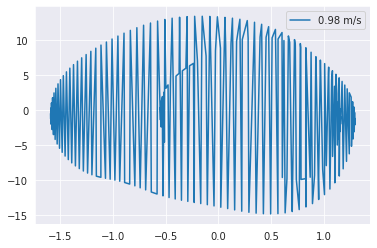

In [152]:
sns.lineplot(x=position_mean[0],y=velocity_mean[0][:-1],label='0.98 m/s')

In [1]:
fig=plt.figure(dpi=300,figsize=(12,12))
ax=fig.add_subplot(111)
for i in range(len(position_mean)-1):
    ax.plot(np.arange(0,198/200,1/200),position_mean[i],label=str(runs[f'{i+1}'])+ ' cm/s')
    ax.fill_between(np.arange(0,198/200,1/200),position_mean[i]-position_std[i],position_mean[i]+position_std[i],alpha=0.2)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Position (cm)')
ax.set_title('COM Position vs Time for different walking speeds')
ax.legend(loc='lower right')

NameError: name 'plt' is not defined

# Delta Y and Delta T

In [193]:
Delta_y=[]
Delta_t=[]
Dys=[]
Dts=[]

for data in acc_data:

    int_data,_=split_datum(data)
    del_y=[]
    del_t=[]
    for i in range(len(int_data)):
        p=instance.get_deltas(data=int_data[i],delta_y=True,delta_t=True,delta_x=False,velocities=True,position=False)
        del_y.append(p[0])
        del_t.append(p[1])
    Delta_y.append(np.mean(del_y,axis=0))
    Delta_t.append(np.mean(del_t,axis=0))
    Dys.append(np.std(del_y,axis=0))
    Dts.append(np.std(del_t,axis=0))



 

(21104,)
89
(21712,)
90


/tmp/ipykernel_5264/1657481095.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_1),np.array(data_raw)


(21264,)
85
(20368,)
84
(21488,)
93
(57584,)
236


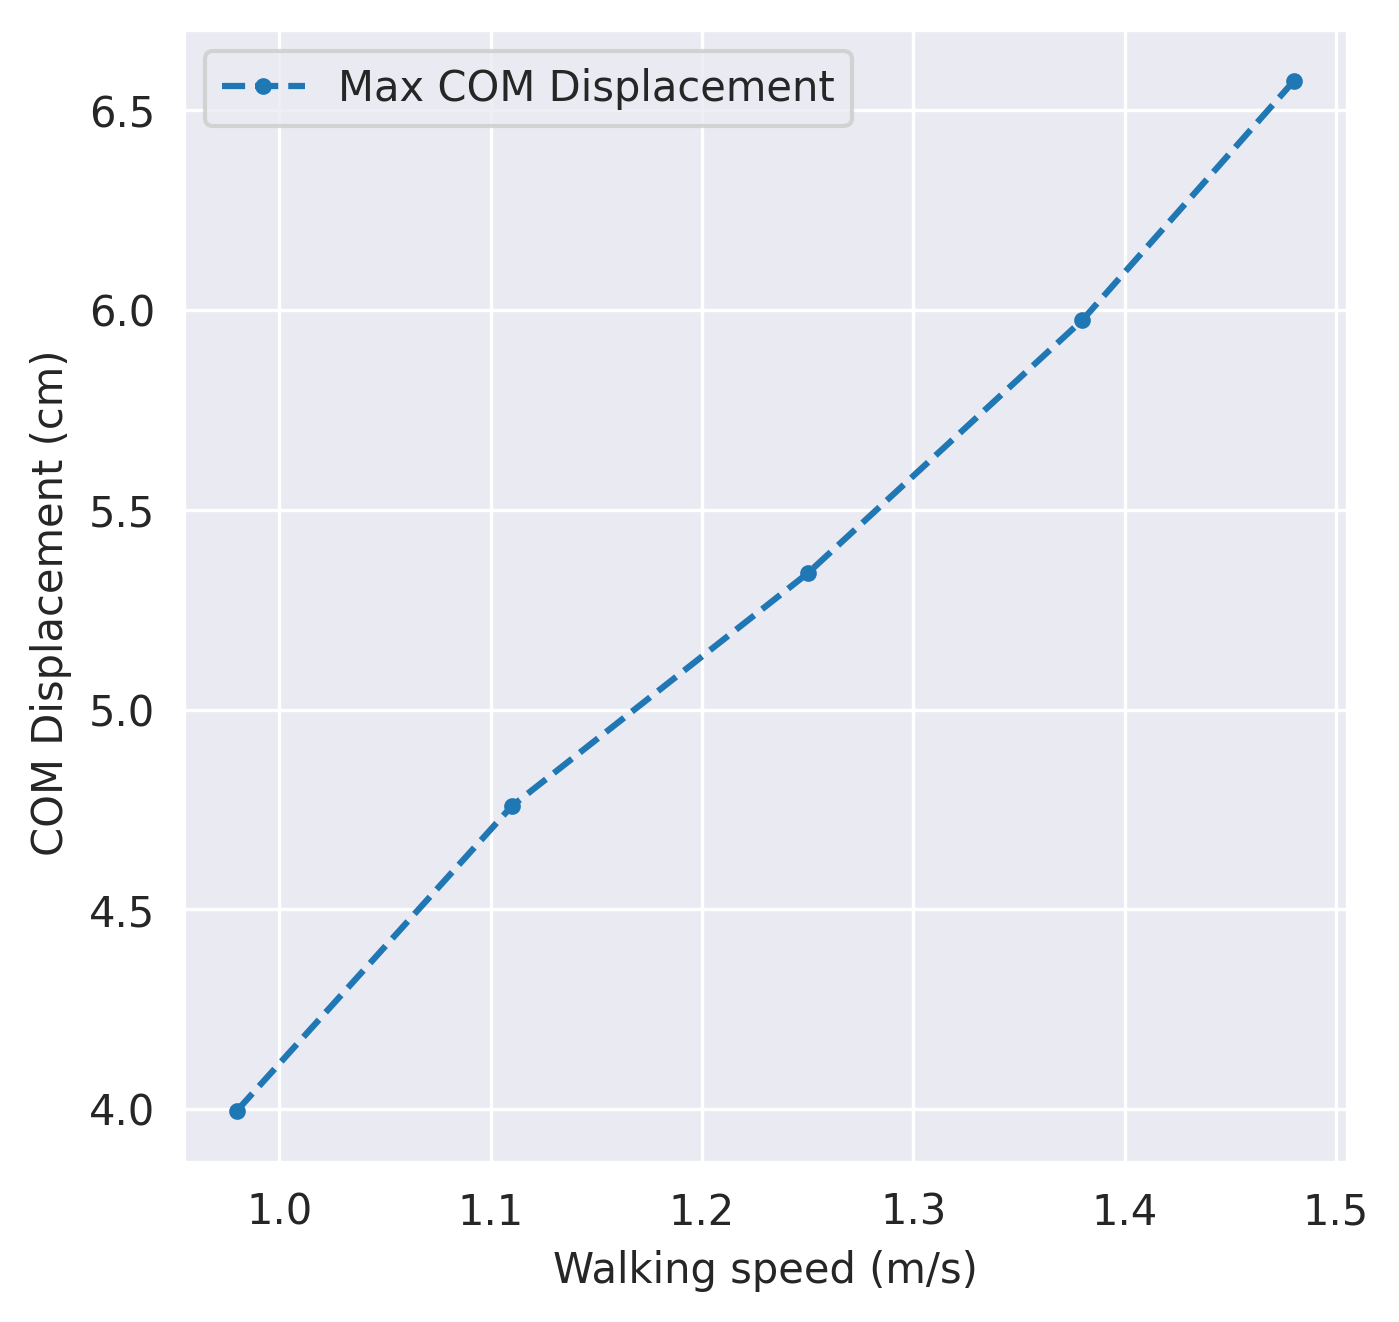

In [219]:
fig=plt.figure(dpi=300,figsize=(5,5))
ax=fig.add_subplot(111)
ax.plot([0.98,1.11,1.25,1.38,1.48],Delta_y[:-1],'.--',label='Max COM Displacement')
#ax.plot([0.98,1.11,1.25,1.38,1.48],Delta_t[:-1],'.--',label='Step Time')
ax.set_xlabel('Walking speed (m/s)')
ax.set_ylabel('COM Displacement (cm) ')
#ax.set_title('Max COM Displacement vs walking speed')
ax.legend(loc='best')

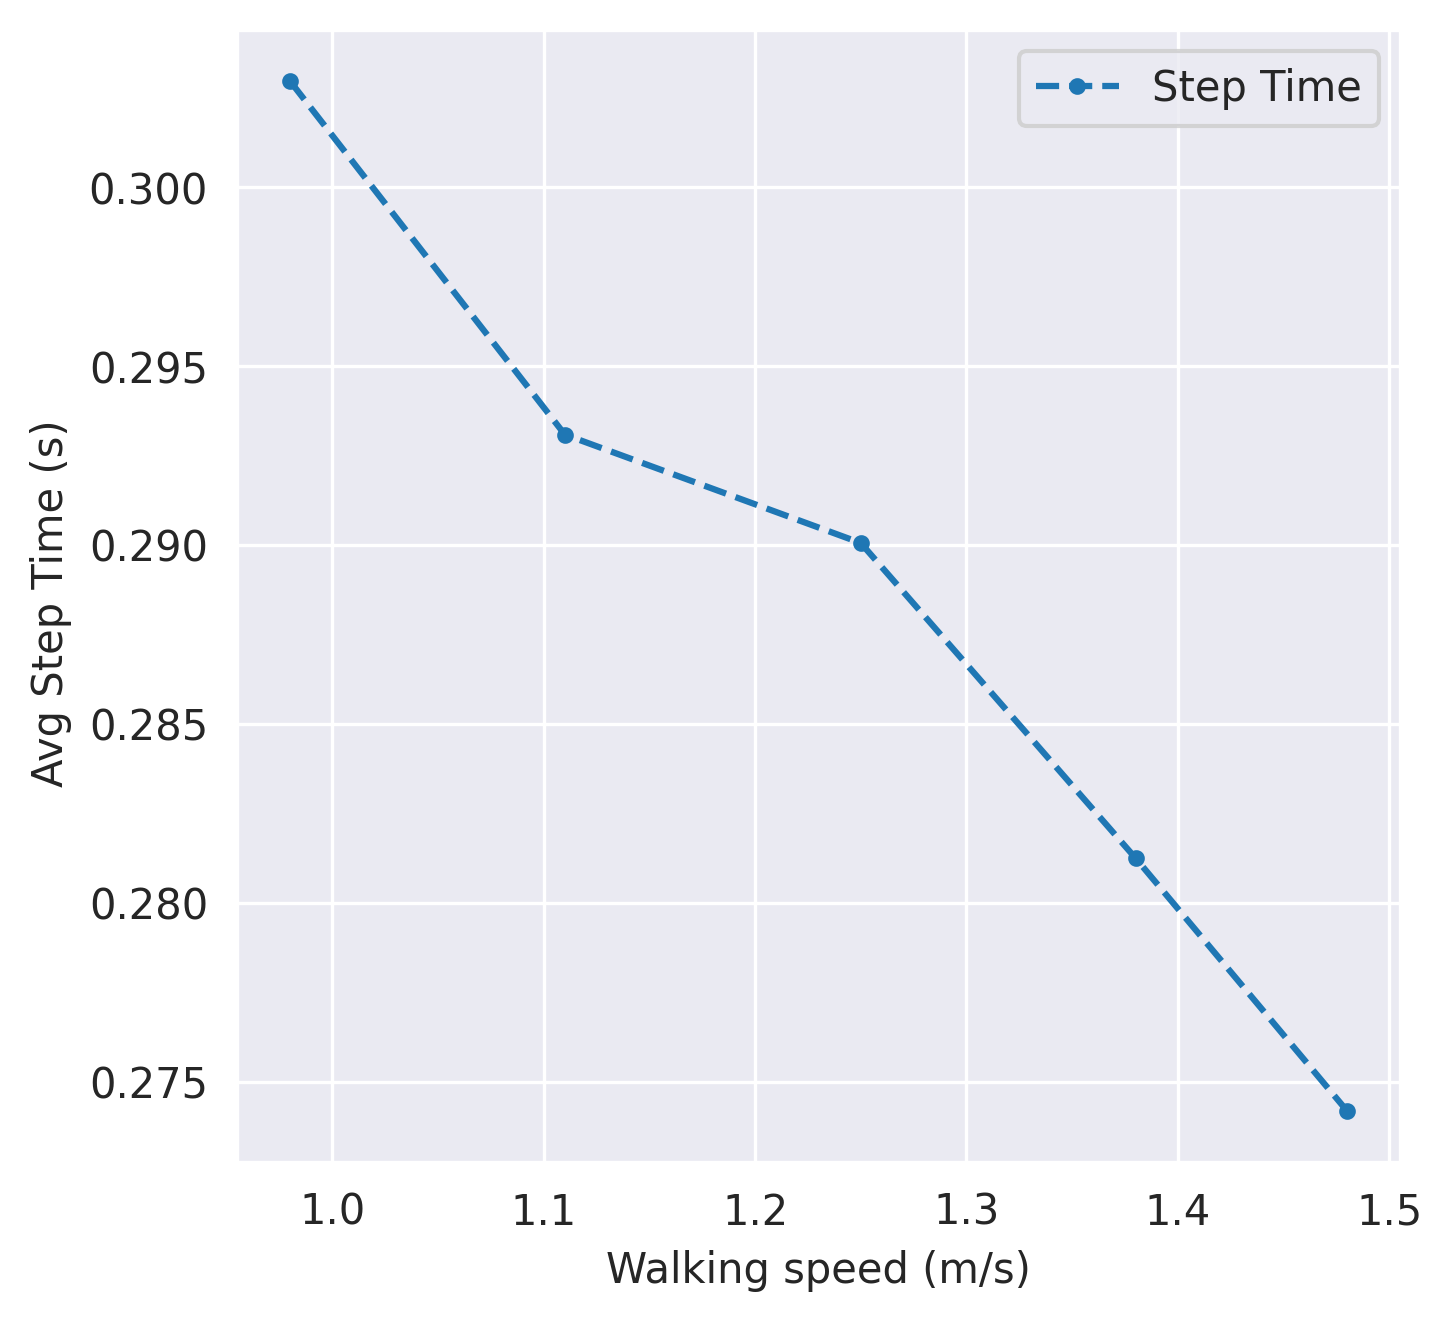

In [220]:
fig=plt.figure(dpi=300,figsize=(5,5))
ax=fig.add_subplot(111)
#ax.plot([0.98,1.11,1.25,1.38,1.48],Delta_y[:-1],'.--',label='Max COM Displacement')
ax.plot([0.98,1.11,1.25,1.38,1.48],Delta_t[:-1],'.--',label='Step Time')
ax.set_xlabel('Walking speed (m/s)')
ax.set_ylabel('Avg Step Time (s) ')
#ax.set_title('Max COM Displacement vs walking speed')
ax.legend(loc='best')

# Trend Filter

In [233]:
speeds=[]
for data in acc_data:

    instance=SRP(h=110,c=1.5)
    int_data,_=split_datum(data)
    for i in range(len(int_data)):
        p=instance.Velocity(data=int_data[i])
        speed=instance.TrendFilt(sh_buf_ln=5,filter_num=2,double_filt_flag=False,r_number=0.05)
    
    speeds.append(instance.Trend_buffer)

2023-04-25 10:22:31.441 (53967.944s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:3f10:1db9:92a0:afdb (Address already in use)
2023-04-25 10:22:31.441 (53967.944s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-04-25 10:22:31.442 (53967.944s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-04-25 10:22:31.442 (53967.944s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:3f10:1db9:92a0:afdb (Address already in use)
2023-04-25 10:22:31.

(21104,)
89
(21712,)
90


2023-04-25 10:22:31.684 (53968.187s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:3f10:1db9:92a0:afdb (Address already in use)
2023-04-25 10:22:31.684 (53968.187s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-04-25 10:22:31.684 (53968.187s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-04-25 10:22:31.684 (53968.187s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:3f10:1db9:92a0:afdb (Address already in use)
2023-04-25 10:22:31.

(21264,)
85
(20368,)
84


2023-04-25 10:22:31.892 (53968.395s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:3f10:1db9:92a0:afdb (Address already in use)
2023-04-25 10:22:31.892 (53968.395s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-04-25 10:22:31.892 (53968.395s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-04-25 10:22:31.892 (53968.395s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:3f10:1db9:92a0:afdb (Address already in use)
2023-04-25 10:22:31.

(21488,)
93
(57584,)
236


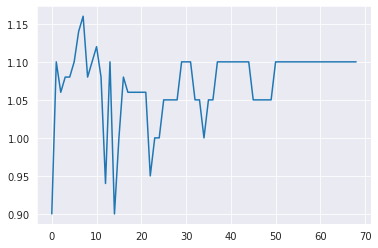

In [234]:
plt.plot(speeds[0])